In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import numpy as np
import keras,gc,nltk
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.special import expit
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
nltk.download('reuters')
nltk.download('wordnet')
%matplotlib inline

from base_networks import *

np.random.seed(20)

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

## Load Data

### 20 Newsgroup
---

Utilizado en trabajos previos de *Hashing* de texto (http://people.csail.mit.edu/jrennie/20Newsgroups), también disponible en **sklearn**. El dataset contiene textos de usuarios asociados a temáticas de noticias etiquetados como pertenenciente a uno de 20 grupos de noticias, el detalle de los conjuntos se detalla a continuación:

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|11.314|20|
|Pruebas|7.532|20|

In [2]:
dat_n = "20News"

from sklearn.datasets import fetch_20newsgroups
newsgroups_t = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
labels = newsgroups_t.target_names

texts_t = newsgroups_t.data
y_t = newsgroups_t.target
labels_t = [labels[valor] for valor in y_t]

texts_test = newsgroups_test.data
y_test = newsgroups_test.target
labels_test = [labels[valor] for valor in y_test]

print("Datos de entrenamiento: ",y_t.shape)
print("Datos de prueba: ",y_test.shape)

Datos de entrenamiento:  (11314,)
Datos de prueba:  (7532,)


Es el dataset con los documentos más extensos en información o textos, lo que podría ser un indicador que es el más difícil ya que se deberá comprimir toda la información presente en estos textos.

### Reuters21578
---
Similar a 20NewsGroup es un datataset de textos de noticias del periodico de Reuters en 1987, citado también en el estado del arte (https://www.nltk.org/book/ch02.html) y disponible en la librería **nltk**. El detalle de los conjuntos se muestra a continuación:

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|7.769|90|
|Pruebas|3.019|90|

Los documentos pueden pertenecer a **múltiples tópicos** dentro de 90 disponibles en el dataset manualmente etiquetadas, ésto es porque un texto asociado a una noticia puede hablar de varios tópicos a la vez. 

In [29]:
dat_n = "Reuters"

from nltk.corpus import reuters
documents_stat = reuters.fileids()
print(str(len(documents_stat)) + " documents")

train_docs_stat = list(filter(lambda doc: doc.startswith("train"), documents_stat))
print(str(len(train_docs_stat)) + " total training documents")
test_docs_stat = list(filter(lambda doc: doc.startswith("test"), documents_stat))
print(str(len(test_docs_stat)) + " total test documents")

texts_t = [reuters.raw(archivo) for archivo in train_docs_stat]
labels_t = [reuters.categories(archivo) for archivo in train_docs_stat]

texts_test = [reuters.raw(archivo) for archivo in test_docs_stat]
labels_test = [reuters.categories(archivo) for archivo in test_docs_stat]

labels = reuters.categories()

10788 documents
7769 total training documents
3019 total test documents


#### top 20 labels (as VDSH)

In [30]:
from utils import get_topK_labels,set_newlabel_list,enmask_data
new_labels = get_topK_labels(labels_t+labels_test, labels, K=20)
labels = new_labels
new_labels

category with most data (earn) has = 3964, the top-K category (bop) has = 105


['earn',
 'acq',
 'money-fx',
 'grain',
 'crude',
 'trade',
 'interest',
 'ship',
 'wheat',
 'corn',
 'dlr',
 'money-supply',
 'oilseed',
 'sugar',
 'coffee',
 'gnp',
 'gold',
 'veg-oil',
 'soybean',
 'bop']

### Reuters Corpus Volume 1
---
Corpus de Reuters extendido, con los 103 tópicos originales. Disponible en trabajos previos (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel.html) y a través de **sklearn** (https://scikit-learn.org/0.17/datasets/rcv1.html). La representación son las *features* ya extraídas.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|23.149|103|
|Pruebas|781.265|103|

Representación de **sklearn** viene pre-procesada con la transformación logarítmica de TF-IDF.

In [20]:
dat_n = "RCV1"

from sklearn.datasets import fetch_rcv1
rcv1_train = fetch_rcv1(subset='train')
rcv1_test = fetch_rcv1(subset='test')
X_t = rcv1_train.data
y_t = rcv1_train.target
X_test = rcv1_test.data
y_test = rcv1_test.target
labels = rcv1_train.target_names

del rcv1_train,rcv1_test
X_train

KeyboardInterrupt: 

In [ ]:
X_t = np.concatenate((X_t,X_test),axis=0)
labels_t = np.concatenate((X_t,X_test),axis=0) #labels


In [ ]:
from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
X_t,X_test,labels_t,labels_test  = train_test_split(X_t,labels_t,random_state=20,test_size=0.1)

X_train,X_val,labels_train,labels_val  = train_test_split(X_t,labels_t,random_state=20,test_size=0.1)

del X_t, labels_t
gc.collect()

print("Vocabulario size = ",X_train.shape[1])
print("Cantidad de datos Entrenamiento: ",len(labels_train))
print("Cantidad de datos Validación: ",len(labels_val))
print("Cantidad de datos Pruebas: ",len(labels_test))

### TMC
---
textos relacionados con reportes aeros de tráfico provistos por la NASA y usados en la competencia de text mining SIAM. Cada texto tiene 22 etiquetas no exlucenyetes.


|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|21,519|22|
|Validación|3,498|22|
|Pruebas|3,498|22|

In [49]:
dat_n = "TMC"

labels = ['a','b','c','d','e','f','e','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u']

El dataset anterior también es extenso en sus documentos pero no tan extremo como 20 Newsgroup.

### SearchSnipet
---
Dataset de Google search *snippets*-- pequeñas porciones de texto que le dan a usuarios una idea de lo que hay en el sitio web en el buscador de Google. Pertenecientes a 8 clases únicas (dominio). Disponibles a través de http://jwebpro.sourceforge.net/data-web-snippets.tar.gz.


|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|10.060|8|
|Pruebas|2.280|8|

In [67]:
dat_n = "Snippets"

def read_file(archivo,symb=' '):
    with open(archivo,'r') as f:
        lineas = f.readlines()
        tokens_f = [linea.strip().split(symb) for linea in lineas]
        labels = [tokens[-1] for tokens in tokens_f]
        tokens = [' '.join(tokens[:-1]) for tokens in tokens_f]
    return labels,tokens
labels_t,texts_t = read_file("Data/data-web-snippets/train.txt")
labels_test,texts_test = read_file("Data/data-web-snippets/test.txt")
print("Datos de entrenamiento: ",len(texts_t))
print("Datos de pruebas: ",len(texts_test))

labels = list(set(labels_t))
labels

Datos de entrenamiento:  10060
Datos de pruebas:  2280


['health',
 'culture-arts-entertainment',
 'computers',
 'engineering',
 'politics-society',
 'business',
 'sports',
 'education-science']

### Validation creation

In [68]:
from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
labels_test = np.asarray(labels_test)
texts_train,texts_val,labels_train,labels_val  = train_test_split(texts_t,labels_t,random_state=20,test_size=0.1)

print("Cantidad de datos Entrenamiento: ",len(texts_train))
print("Cantidad de datos Validación: ",len(texts_val))
print("Cantidad de datos Pruebas: ",len(texts_test))

Cantidad de datos Entrenamiento:  9054
Cantidad de datos Validación:  1006
Cantidad de datos Pruebas:  2280


## Pre-process
---
Para obtener la representación de los datos, en primer lugar se normalizan con experimentar dos tipos de pre-procesamiento:

1. El primero es el siguiente (Basado en Deep Semantic Hashing)
    * Pasar letras a minúsculas
    * Eliminar extra espacios (saltos de línea por ejemplo)
    * Remover stop words
    * Borrar todo lo que no sea letras (eliminar números y puntuaciones)
    * Conservar las top $k$ palabras/*tokens* más frecuentes
2. El segundo añade lo siguiente (Basado en Semantic Hashing)
    * Se realiza un *stemming* (Snowball) -- Lemmatization
    * Remover palabras de menos de 3 largo


Para la representación vectorial se utiliza lo siguiente:
* TF-IDF: 
$$ w_f(d) \cdot \left(1 + log\left( \frac{1+n_d}{1+df_w} \right) \right)$$
* **TF (*term frequency*)**: $$ w_f(d) $$
* Binary: $$I(w_f(d) \neq 0)$$

La representación *term frequency* es la que se toma como base, puesto que resulta natural al momento de reconstruir el dato y poder utilizar la función de pérdida *cross entropy*. Ya que para la representación *tf-idf* requeriría una función de pérdida adecuada para variable continua, que podría ser *mse*.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
#analyzer = TfidfVectorizer(ngram_range=(1, 3)).build_analyzer()
tokenizer = TfidfVectorizer().build_tokenizer()
stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()

"""Extract features from raw input"""
def preProcess(s): #String processor
    return s.lower().strip().strip('-').strip('_')
def number_normalize(doc):
    results = []
    for token in tokenizer(doc):
        token_pro = preProcess(token)
        if len(token_pro) != 0 and not token_pro[0].isdigit():
            results.append(token_pro)
    return results
def stemmed_words(doc):
    results = []
    for token in tokenizer(doc):
        pre_pro = preProcess(token)
        #token_pro = stemmer.stem(pre_pro) #aumenta x10 el tiempo de procesamiento
        token_pro = lemmatizer.lemmatize(pre_pro) #so can explain/interpretae -- aumenta x5 el tiempo de proce
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

def get_transform_representation(mode, analizer,min_count,max_feat):
    smooth_idf_b = False
    use_idf_b = False
    binary_b = False

    if mode == 'binary':
        binary_b = True
    elif mode == 'tf':     
        pass #default is tf
    elif mode == 'tf-idf':
        use_idf_b = True
        smooth_idf_b = True #inventa 1 conteo imaginario (como priors)--laplace smoothing
    return TfidfVectorizer(stop_words='english',tokenizer=analizer,min_df=min_count, max_df=0.8, max_features=max_feat
                                ,binary=binary_b, use_idf=use_idf_b, smooth_idf=smooth_idf_b,norm=None
                                  ,ngram_range=(1, 3)) 

min_count = 1 #default = 1
max_feat = 10000 #Best: 10000 -- Hinton (2000)


vectorizer = get_transform_representation("tf", stemmed_words,min_count,max_feat)

%time vectorizer.fit(texts_train)
vectors_train = vectorizer.transform(texts_train)
vectors_val = vectorizer.transform(texts_val)
vectors_test = vectorizer.transform(texts_test)

token2idx = vectorizer.vocabulary_
idx2token = {idx:token for token,idx in token2idx.items()}

#vectorizer2 = get_transform_representation("tf-idf", stemmed_words,min_count,max_feat)

#%time vectorizer2.fit(texts_train)
#vectors_train2 = vectorizer2.transform(texts_train)
#vectors_val2 = vectorizer2.transform(texts_val)
#vectors_test2 = vectorizer2.transform(texts_test)
vectors_train.shape

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 2.92 s, sys: 19 ms, total: 2.94 s
Wall time: 3.23 s


(9054, 10000)

En la celda anterior se calculan dos representaciones deseables de los datos, *term frequency* y *tf-idf*. A continuación se muestra cómo quedó el vocabulario.

In [70]:
#todense --get representation
X_train = np.asarray(vectors_train.todense())
X_val = np.asarray(vectors_val.todense())
X_test = np.asarray(vectors_test.todense())

#X_train2 = np.asarray(vectors_train2.todense())
#X_val2 = np.asarray(vectors_val2.todense())
#X_test2 = np.asarray(vectors_test2.todense())

del vectors_train,vectors_val,vectors_test#,vectors_train2,vectors_val2,vectors_test2
gc.collect()

X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

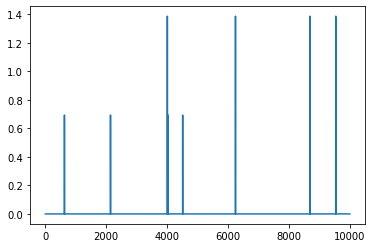

In [71]:
##representacion soft para TF ---mucho mejor!
X_train_input = np.log(X_train+1) 
X_val_input = np.log(X_val+1) 
X_test_input = np.log(X_test+1) 
plt.plot(X_train_input[0])
plt.show()

#soft para tf-idf
#X_train_input2 = np.log(X_train2+1) 
#X_val_input2 = np.log(X_val2+1) 
#X_test_input2 = np.log(X_test2+1) 

### Model Architecture
---
La arquitectura para afrontar el problema es una red clásica *Feed Forward* basado en el *baseline* de *Variational Deep Semantic Hashing* (VDSH), la cual es una arquitectura de *autoencoder* no simétrico con dos capas escondidas en el *encoder* y sin capas escondidas en el *decoder*.


> Input(|V|) -> Relu(500) -> Relu (500) -> Laten variable(32)-> Sampling -> Softmax(|V|)


Tamién se experimenta con una arquitectura de autoencoder simétrico, lo cual asimila de mejor manera lo que es una RBM (red bidireccional) como se realiza en el trabajo de *Semantic Hashing*.

La primera experimentación se realiza con 32 *bits* en la representación latente, ya que los trabajos previos han mostrado que esta cantidad de *bits* parece ser lo suficiente antes de empezar a realizar *overfitting*.

In [3]:
def REC_loss(x_true, x_pred):
    x_pred = K.clip(x_pred, K.epsilon(), 1)
    return - K.sum(x_true*K.log(x_pred), axis=-1) #keras.losses.categorical_crossentropy(x_true, x_pred)


In [4]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True, summ=True, beta=0):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    if summ:
        print("pre-encoder network:")
        pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    if summ:
        print("generator network:")
        generator.summary()

    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)
        
    Recon_loss = REC_loss
    kl_loss = KL_loss(z_mean,z_log_var)
    def VAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt, loss=VAE_loss, metrics = [Recon_loss,kl_loss])
    
    return traditional_vae, encoder,generator

In [5]:
import keras.backend as K
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)


def binary_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True, summ=True,tau_ann=False,beta=0):
    if tau_ann:
        tau = K.variable(1.0, name="temperature") 
    else:
        tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3
    
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    if summ:
        print("pre-encoder network:")
        pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    if summ:
        print("generator network:")
        generator.summary()

    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    #dist = Dense(Nb, activation='sigmoid')(hidden) #p(b) #otra forma de modelarlo
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)
        
    Recon_loss = REC_loss
    kl_loss = BKL_loss(logits_b)
    def BVAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=BVAE_loss, metrics = [Recon_loss,kl_loss])
    if tau_ann:
        return binary_vae, encoder,generator ,tau
    else:
        return binary_vae, encoder,generator

### Train details
---

* 30* epochs* 
* *batch size* de 100
* optimizador Adam
* Inicializador de Glorot (para los pesos)


In [6]:
from utils import  compare_hist_train, add_hist_plot

batch_size = 100
epochs = 30

In [50]:
#from utils_VDSH import Load_Dataset
from utils import Load_Dataset

#https://github.com/unsuthee/VariationalDeepSemanticHashing
## load data used for VDSH - for sake comparison


#filename = 'Data/ng20.tfidf.mat'
#filename = 'Data/reuters.tfidf.mat'
filename = 'Data/tmc.tfidf.mat'
data = Load_Dataset(filename)

X_train_input = data["train"]
X_train = X_train_input 
X_val_input = data["cv"]
X_val = X_val_input 
X_test_input = data["test"]
X_test = X_test_input


if "ng20" in filename:
    labels_train = np.asarray([labels[value.argmax(axis=-1)] for value in data["gnd_train"]])
    labels_val = np.asarray([labels[value.argmax(axis=-1)] for value in data["gnd_cv"]])
    labels_test = np.asarray([labels[value.argmax(axis=-1)] for value in data["gnd_test"]])
elif "reuters" in filename or "tmc" in filename:
    labels = np.asarray(labels)
    labels_train = np.asarray([labels[value.astype(bool)] for value in data["gnd_train"]])
    labels_val = np.asarray([labels[value.astype(bool)] for value in data["gnd_cv"]])
    labels_test = np.asarray([labels[value.astype(bool)] for value in data["gnd_test"]])

print("Cantidad de datos Entrenamiento: ",len(labels_train))
print("Cantidad de datos Validación: ",len(labels_val))
print("Cantidad de datos Pruebas: ",len(labels_test))
labels_train

Cantidad de datos Entrenamiento:  21286
Cantidad de datos Validación:  3498
Cantidad de datos Pruebas:  3498


array([array(['a', 'b'], dtype='<U1'),
       array(['e', 'i', 'k', 'r'], dtype='<U1'),
       array(['f', 'g', 'l'], dtype='<U1'), ...,
       array(['i', 'l', 'q'], dtype='<U1'), array(['b'], dtype='<U1'),
       array(['b', 'd', 'i', 'q', 'r'], dtype='<U1')], dtype=object)

# IMPORTANTE EJECUTAR, nueva modificación!

In [72]:
#outputs as probabolities -- normalized over datasets..
X_train = X_train/X_train.sum(axis=-1,keepdims=True) 
X_val = X_val/X_val.sum(axis=-1,keepdims=True)
X_test = X_test/X_test.sum(axis=-1,keepdims=True)
print("Output target normalizado en dataset ",dat_n)

Output target normalizado en dataset  Snippets


/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [73]:
X_train[np.isnan(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_test[np.isnan(X_test)] = 0

In [12]:
from utils import find_beta

def create_model_T(beta_V):
    return traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0
                                                                  ,beta=beta_V, summ=False)
def create_model_B(beta_V):
    return binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0
                                                                  ,beta=beta_V, summ=False)

In [33]:
beta_T = find_beta(create_model_T, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=False, E=50)
beta_B = find_beta(create_model_B, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=True, E=40)

***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.1295
1,0.500000,0.1145
2,0.250000,0.1211
3,0.125000,0.1493
4,0.062500,0.2820
5,0.031250,0.5243
6,0.015625,0.5240
7,0.007812,0.5182
8,0.003906,0.5076
9,0.001953,0.5174


Best value is 0.5331 with beta 0.000004
Worst value is 0.1145 with beta 0.500000
***************************************


In [10]:
### valores para 20NEWS!!

beta_T = 0.06250
beta_B = 0.015625

In [34]:
### valores para REUTERS!!
beta_T = 0.06250
beta_B = 0.000008

In [53]:
### valores para TMC!!
beta_T = 0.06250
beta_B = 0.000244

In [74]:
### valores para SNIPPETS!!
beta_T = 0.125000
beta_B = 0.015625

In [75]:
X_total_input = np.concatenate((X_train_input,X_val_input),axis=0)
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)

In [76]:
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta=beta_T)

hist1 = traditional_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_test_input,X_test))

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               5000500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000

In [77]:
binary_vae,encoder_Bvae,generator_Bvae= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta=beta_B)

hist2 = binary_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_test_input,X_test) )
                       #,callbacks=[Tau_Call(tau)] )

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               5000500   
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1000

In [38]:
## kl increase va a depender netamente del problema, que tan rapido aprende el modelo y como vaariar eso..

### Another intrinsic measure: *Classification*


In [14]:
#function to define and train model
from sklearn.metrics import jaccard_score
from utils import define_fit, visualize_probas, visualize_mean, calculate_hash, visualize_probas_byB

results = []
results_S = []
results_B = []
results_O_B = [] #original testing on tresholded

In [78]:
#codify input data (binarize -- or aprox)
X_train_logits = encoder_Bvae.predict(X_total_input)
X_val_logits = encoder_Bvae.predict(X_test_input)

#probabilities
X_train_Bcode = expit(X_train_logits)
X_val_Bcode = expit(X_val_logits)

#Z-mean
X_train_Tcode = encoder_Tvae.predict(X_total_input)
X_val_Tcode = encoder_Tvae.predict(X_test_input)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list or type(aux_labels) == np.ndarray :
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_total)
C_val = codify_labels(labels_test)
C_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [79]:
aux = [dat_n]
multi_label = "Reuters" in aux or "TMC" in aux

model1_O = define_fit(multi_label,X_train_Bcode,C_train)
model2_O = define_fit(multi_label,X_train_Tcode,C_train)
model3 = define_fit(multi_label,X_total_input,C_train)

if not multi_label:
    aux.append(model3.evaluate(X_total_input,C_train,verbose=0)[1])
    aux.append(model3.evaluate(X_test_input,C_val,verbose=0)[1])

    aux.append(model2_O.evaluate(X_train_Tcode,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model3.predict(X_total_input)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model3.predict(X_test_input)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

Done


In [80]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Raw Input (train-val): %f - %f"%(valores[1],valores[2]))
    print("Traditional VAE (train-val): %f - %f"%(valores[3],valores[4]))
    print("Binary VAE (train-val): %f - %f"%(valores[5],valores[6]))


Accuracy on dataset:  20News
Raw Input (train-val): 0.999523 - 0.906761
Traditional VAE (train-val): 0.849350 - 0.784351
Binary VAE (train-val): 0.826057 - 0.768266

Accuracy on dataset:  Reuters
Raw Input (train-val): 0.990956 - 0.851508
Traditional VAE (train-val): 0.797300 - 0.786197
Binary VAE (train-val): 0.748453 - 0.728665

Accuracy on dataset:  TMC
Raw Input (train-val): 0.971480 - 0.430312
Traditional VAE (train-val): 0.529945 - 0.458556
Binary VAE (train-val): 0.532579 - 0.453345

Accuracy on dataset:  Snippets
Raw Input (train-val): 0.998907 - 0.698246
Traditional VAE (train-val): 0.898907 - 0.701754
Binary VAE (train-val): 0.891948 - 0.673246


Ahora es mejor para reconstruir ya que el modelo VAE al concentrarse mas en la KL (peso mas alto) olvida mejorar la reconstrucción y los patrones de los datos

In [81]:
## binary // treshold it

X_train_Tcode_B = calculate_hash(X_train_Tcode, from_probas=False)
X_val_Tcode_B = calculate_hash(X_val_Tcode, from_probas=False)

X_train_Bcode_B = calculate_hash(X_train_Bcode, from_probas=True, from_logits=False)
X_val_Bcode_B = calculate_hash(X_val_Bcode, from_probas=True, from_logits=False)

X_train_Tcode_B

array([[0, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]], dtype=int32)

In [82]:
### trained models over encoder representation testing on tresholded representation (see how decrease)

aux = [dat_n]
multi_label = "Reuters" in aux or "TMC" in aux
if not multi_label:
    aux.append(model2_O.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_O_B.append(aux)
print("Done")

Done


In [83]:
print("Classification on Binary (thresholded) representation")
for valores in results_O_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary (thresholded) representation

Accuracy on dataset:  20News
Traditional VAE (train-val): 0.421440 - 0.404308
Binary VAE (train-val): 0.785398 - 0.730916

Accuracy on dataset:  Reuters
Traditional VAE (train-val): 0.467864 - 0.462428
Binary VAE (train-val): 0.746070 - 0.723512

Accuracy on dataset:  TMC
Traditional VAE (train-val): 0.318780 - 0.271784
Binary VAE (train-val): 0.529306 - 0.445516

Accuracy on dataset:  Snippets
Traditional VAE (train-val): 0.504871 - 0.407018
Binary VAE (train-val): 0.874950 - 0.647807


In [84]:
aux = [dat_n]
multi_label = "Reuters" in aux or "TMC" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)
model2 = define_fit(multi_label,X_train_Tcode_B,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

Done


In [85]:
print("Classification on Binary (thresholded) representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary (thresholded) representation

Accuracy on dataset:  20News
Traditional VAE (train-val): 0.749574 - 0.711559
Binary VAE (train-val): 0.796636 - 0.735823

Accuracy on dataset:  Reuters
Traditional VAE (train-val): 0.718972 - 0.709104
Binary VAE (train-val): 0.741730 - 0.719477

Accuracy on dataset:  TMC
Traditional VAE (train-val): 0.498211 - 0.431998
Binary VAE (train-val): 0.528525 - 0.444090

Accuracy on dataset:  Snippets
Traditional VAE (train-val): 0.825547 - 0.612281
Binary VAE (train-val): 0.880119 - 0.648246


### Results
---
#### Proceso de evaluación (*content-based retrieval*)
> *Query*: **Documento**

1. Calcular código hashing/binario de cada dato/documento
    * Para *VAE* tradicional se utiliza la mediana de cada componente como *treshold*
    * Para *VAE* binario se utiliza el *treshold* de 0.5 en la probabilidad
2. Recuperar documentos basado en *match* perfecto, *top K* o *ball search* de distancia *hamming* de un documento consulta.
    * En el mismo conjunto/*set*
    * Con *query* recupero sobre *database*
3. Medir *precision* y *recall* en base a algún criterio de relevancia.
    * Documento relevante a otro o no -> Si comparten al menos una clase.
    

In [23]:
from utils import MedianHashing, get_similar, measure_metrics, calculate_hash
from utils import MAP_atk, M_P_atk, AP_atk

### Experimentando variando el #Bits
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [24]:
def evaluate_hashing_DE(train_hash,test_hash,labels_trainn,labels_testt,tipo="topK",eval_tipo='PRatk',K=100):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    test_similares_train =  get_similar(test_hash,train_hash,tipo=tipo,K=K)
    if eval_tipo=="MAP":
        return MAP_atk(test_similares_train,labels_query=labels_testt, labels_source=labels_trainn, K=0) #all ranking
    elif eval_tipo == "PRatk":
        return measure_metrics(labels,test_similares_train,labels_testt,labels_source=labels_trainn)
    elif eval_tipo == "Patk":
        return M_P_atk(test_similares_train, labels_query=labels_testt, labels_source=labels_trainn, K=K)

def hash_data(model, x_train, x_test, binary=True):
    encode_train = model.predict(x_train)
    encode_test = model.predict(x_test)
    
    train_hash = calculate_hash(encode_train, from_probas=binary )
    test_hash = calculate_hash(encode_test, from_probas = binary)
    return train_hash, test_hash

In [25]:
traditional_dat = {"20news":{"p":[],"r":[]},
                   "snippets":{"p":[],"r":[]},
                   "reuters":{"p":[],"r":[]},
                  "tmc":{"p":[],"r":[]}}
binary_dat = {"20news":{"p":[],"r":[]},
              "snippets":{"p":[],"r":[]},
              "reuters":{"p":[],"r":[]},
             "tmc":{"p":[],"r":[]}}

In [86]:
Nbits = np.asarray([4,8,16,32,64])
dataset = dat_n.lower()
print(dataset)

for Nbit in Nbits:
    traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_T)
    traditional_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size,verbose=0)
    total_hash_VAE, test_hash_VAE = hash_data(encoder_Tvae,X_total_input,X_test_input, binary=False)

    p_t,r_t = evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,tipo="topK")
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    
    binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_B)
    binary_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size,verbose=0 )
    total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_total_input,X_test_input)

    p_b,r_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
    keras.backend.clear_session()
    gc.collect()

snippets
pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               2000      
_________________________________________________________________
dense_18 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_6 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (N

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               5000500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000

In [87]:
print("Resultados de Precision en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = traditional_dat["20news"]["p"]
t["Reuters"] = traditional_dat["reuters"]["p"]
t["Snippets"] = traditional_dat["snippets"]["p"]
t["TMC"] = traditional_dat["tmc"]["p"]
print("\n*** VAE Traditional***")
print(t.T)

t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = binary_dat["20news"]["p"]
t["Reuters"] = binary_dat["reuters"]["p"]
t["Snippets"] = binary_dat["snippets"]["p"]
t["TMC"] = binary_dat["tmc"]["p"]
print("\n*** VAE Binary***")
print(t.T)

print("\nResultados de Recall en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = traditional_dat["20news"]["r"]
t["Reuters"] = traditional_dat["reuters"]["r"]
t["Snippets"] = traditional_dat["snippets"]["r"]
t["TMC"] = traditional_dat["tmc"]["r"]
print("\n*** VAE Traditional***")
print(t.T)

t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = binary_dat["20news"]["r"]
t["Reuters"] = binary_dat["reuters"]["r"]
t["Snippets"] = binary_dat["snippets"]["r"]
t["TMC"] = binary_dat["tmc"]["r"]
print("\n*** VAE Binary***")
print(t.T)

Resultados de Precision en validación

*** VAE Traditional***
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
20News    0.190144  0.360177   0.478850   0.536148   0.582287
Reuters   0.509959  0.681324   0.730910   0.772596   0.799586
Snippets  0.205728  0.313623   0.421509   0.479193   0.474447
TMC       0.581810  0.650026   0.682196   0.702690   0.722281

*** VAE Binary***
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
20News    0.218582  0.353732   0.551379   0.563806   0.540613
Reuters   0.455346  0.638511   0.761768   0.803289   0.787260
Snippets  0.156048  0.344667   0.482996   0.517167   0.502075
TMC       0.543859  0.636349   0.701964   0.723608   0.704914

Resultados de Recall en validación

*** VAE Traditional***
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  6

### MAP

In [27]:
results_map = {}
results_p5000 = {}

In [88]:
Nbits = np.asarray([4,8,16,32,64])
dataset = dat_n.lower()

results_map[dataset] = {"vdsh":[], "bvae":[]}
results_p5000[dataset] = {"vdsh":[], "bvae":[]}

for Nbit in Nbits:
    traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_total_input.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_T)
    traditional_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size, verbose=0)
    total_hash_VAE, test_hash_VAE = hash_data(encoder_Tvae,X_total_input,X_test_input, binary=False)
    
    map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
    results_map[dataset]["vdsh"].append(map_t) 
    p5k_t = evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
    results_p5000[dataset]["vdsh"].append(p5k_t) 
    del traditional_vae, encoder_Tvae, generator_Tvae, total_hash_VAE, test_hash_VAE
    keras.backend.clear_session()
    gc.collect()
    
    binary_vae,encoder_Bvae,generator_Bvae= binary_VAE(X_total_input.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_B)
    binary_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size, verbose=0 )
    total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_total_input,X_test_input)

    map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
    results_map[dataset]["bvae"].append(map_b) 
    p5k_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
    results_p5000[dataset]["bvae"].append(p5k_b) 
    del binary_vae, encoder_Bvae, generator_Bvae, total_hash_BVAE, test_hash_BVAE
    keras.backend.clear_session()
    gc.collect()

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               5000500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               5000500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000

In [89]:
print("\nResultados de MAP baseline VDSH")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = results_map["20news"]["vdsh"]
t["Reuters"] = results_map["reuters"]["vdsh"]
t["TMC"] = results_map["tmc"]["vdsh"]
t["Snippets"] = results_map["snippets"]["vdsh"]
print(t.T)

print("\nResultados de MAP proposal B-VAE")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = results_map["20news"]["bvae"]
t["Reuters"] = results_map["reuters"]["bvae"]
t["TMC"] = results_map["tmc"]["bvae"]
t["Snippets"] = results_map["snippets"]["bvae"]
print(t.T)


Resultados de MAP baseline VDSH
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
20News    0.155396  0.232945   0.305911   0.380244   0.420678
Reuters   0.444329  0.575396   0.527764   0.610194   0.638079
TMC       0.517761  0.525473   0.542988   0.558376   0.587390
Snippets  0.176747  0.243381   0.280135   0.300114   0.335936

Resultados de MAP proposal B-VAE
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
20News    0.213947  0.277323   0.392858   0.371965   0.313554
Reuters   0.424511  0.508233   0.618551   0.589735   0.536851
TMC       0.513850  0.539820   0.559803   0.556420   0.529839
Snippets  0.157278  0.271857   0.305895   0.329780   0.297100


In [90]:
print("\nResultados de P@5000 baseline VDSH")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = results_p5000["20news"]["vdsh"]
t["Reuters"] = results_p5000["reuters"]["vdsh"]
t["TMC"] = results_p5000["tmc"]["vdsh"]
t["Snippets"] = results_p5000["snippets"]["vdsh"]
print(t.T)

print("\nResultados de MAP proposal B-VAE")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = results_p5000["20news"]["bvae"]
t["Reuters"] = results_p5000["reuters"]["bvae"]
t["TMC"] = results_p5000["tmc"]["bvae"]
t["Snippets"] = results_p5000["snippets"]["bvae"]
print(t.T)


Resultados de P@5000 baseline VDSH
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
20News    0.103188  0.112450   0.119118   0.127257   0.132508
Reuters   0.332040  0.362683   0.348024   0.368383   0.376327
TMC       0.541001  0.537547   0.550605   0.567184   0.591222
Snippets  0.158501  0.182261   0.186041   0.189241   0.196206

Resultados de MAP proposal B-VAE
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
20News    0.120017  0.126814   0.128579   0.124503   0.117453
Reuters   0.327887  0.348460   0.359632   0.343994   0.326402
TMC       0.529515  0.552976   0.568279   0.559600   0.533851
Snippets  0.145197  0.182262   0.189499   0.194021   0.188258
